<a href="https://colab.research.google.com/github/Badal3000/Badal3000/blob/main/timeseriesforecastingcomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [ ]:
def plot_series(time, series, format="_", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("time")
    plt.ylabel("value")
    if label:
      plt.legend(fontsize = 14)

    plt.grid(True)

In [ ]:
def trend(time , slope = 0):
  return time* slope

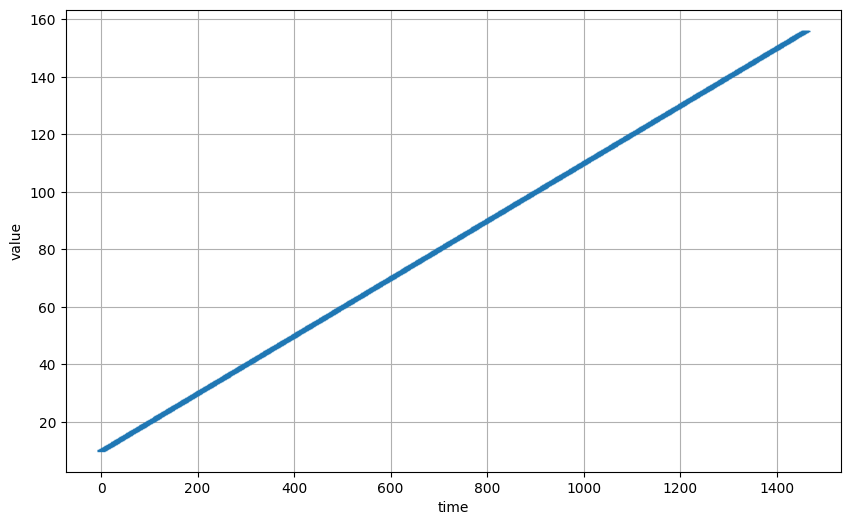

In [ ]:
time = np.arange(4 *365 +1)
baseline = 10
series = baseline + trend(time , 0.1)

plt.figure(figsize=(10 ,6))
plot_series(time, series)
plt.show()

In [ ]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [ ]:
series


array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

generate a seasonal pattern

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time *2 *np.pi),
                  1/np.exp(3*season_time))

def seasonality(time , period, amplitude = 1, phase = 0):
  season_time=((time + phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

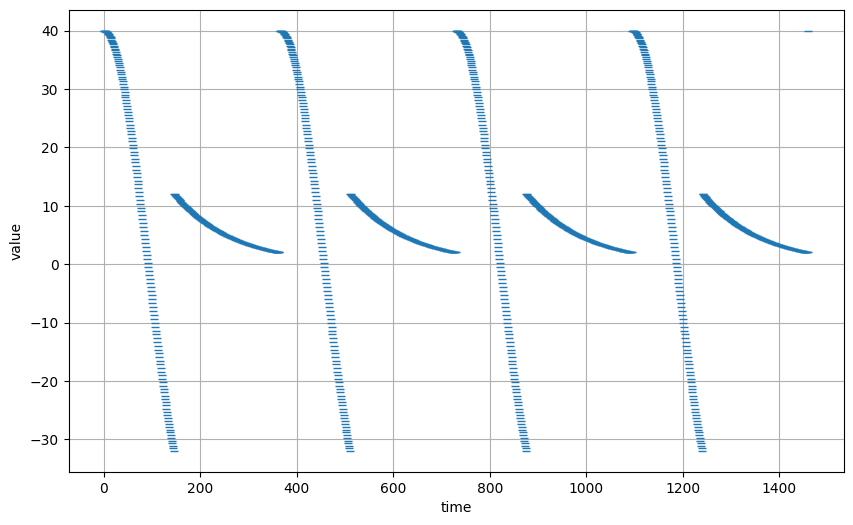

In [ ]:
amplitude = 40
series = seasonality(time, period  = 365, amplitude = amplitude, )

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

time series forecasting for trend and seasonality


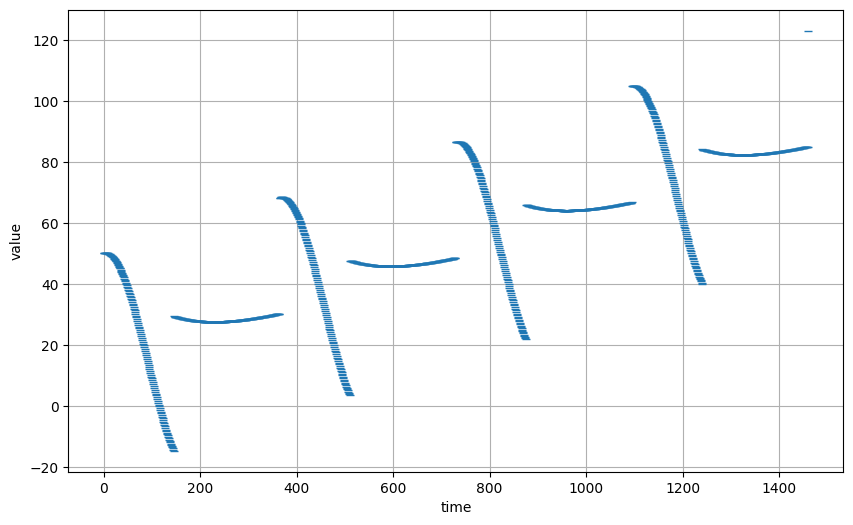

In [ ]:
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time, period = 365, amplitude=amplitude)

plt.figure(figsize = (10,6))
plot_series(time, series)
plt.show()

time series forecasting for white noise

In [ ]:
def white_noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

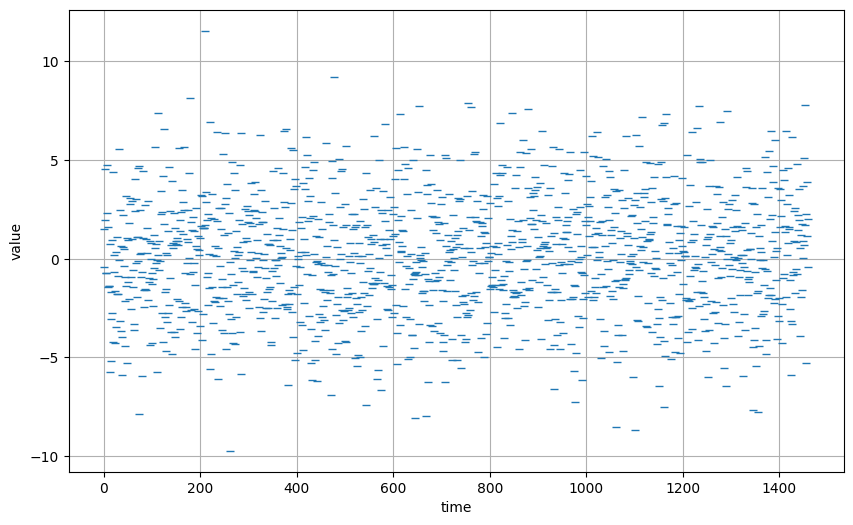

In [ ]:
noise_level = 3
noise = white_noise(time, noise_level, seed = 42)

plt.figure(figsize=(10,6))
plot_series(time, noise)
plt.show()

add noise to time series forecasting as noise+series


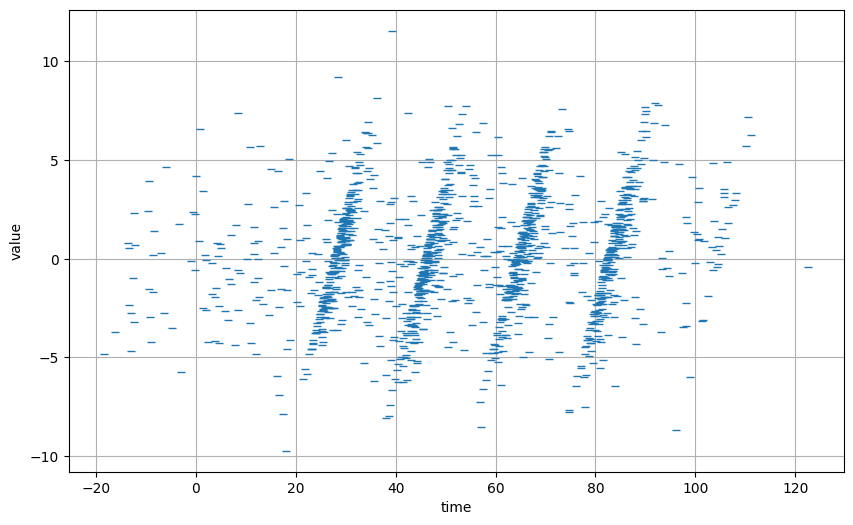

In [ ]:
series+=noise

plt.figure(figsize=(10,6))
plot_series(series, noise)
plt.show()

we will s-lit this into  two periods
1.training period
2.validation period
the spit will be at time step 1000

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive forecasting

In [ ]:
naive_forecast = series [split_time - 1:-1]

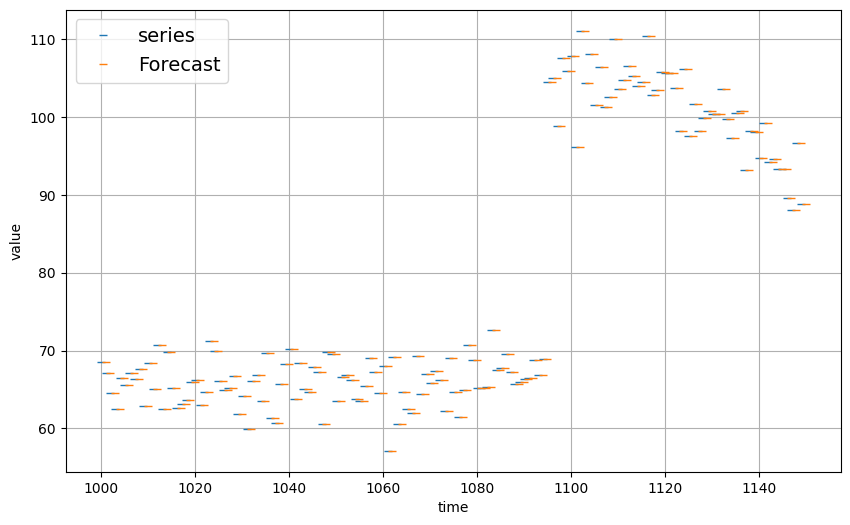

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start = 0, end = 150, label="series")
plot_series(time_valid, naive_forecast, start = 1, end = 151, label="Forecast")

computing the mean absolute error between the forecast and the prediction

In [ ]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

3.6735787124374184

metrics mean absolute error

In [ ]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

3.6735787124374184

moving average


In [ ]:
def moving_average_series(series, window_size):
  forecast = []
  for time in range(len(series)-window_size):
    forecast.append(series[time:time+window_size].mean())
  return np.array(forecast)

In [ ]:
def moving_average_forecast(series, window_size):
  """the mean of the last four values.
  if window_size = 1 then this is equivalent to naive forecast"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size


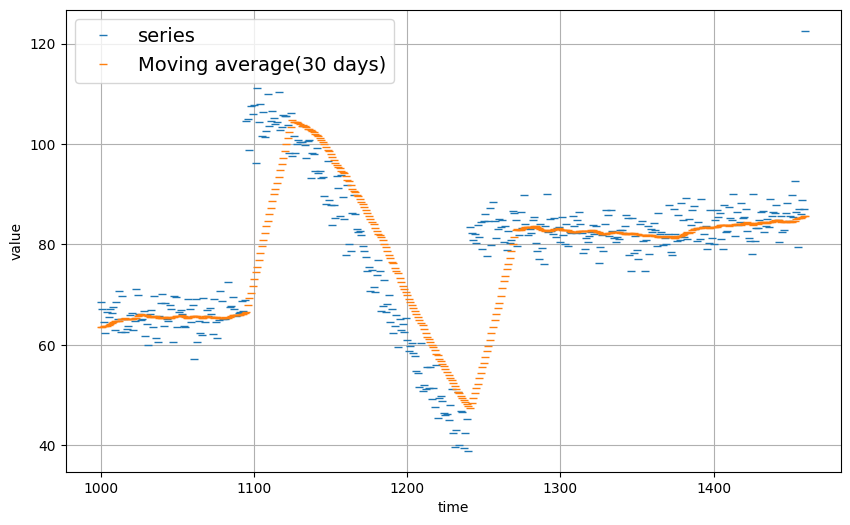

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="series")
plot_series(time_valid, moving_avg, label="Moving average(30 days)")

In [ ]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

6.078927226720083

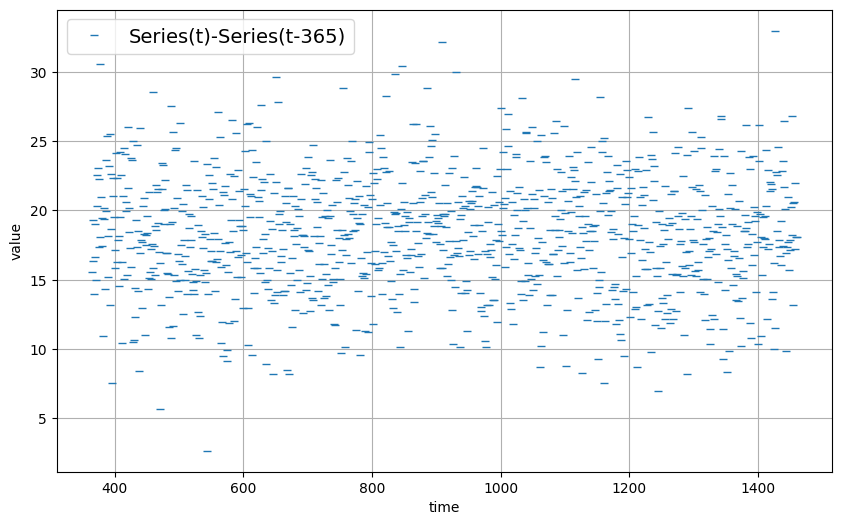

In [ ]:
diff_series=(series[365:]-series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label = "Series(t)-Series(t-365)")
plt.show()

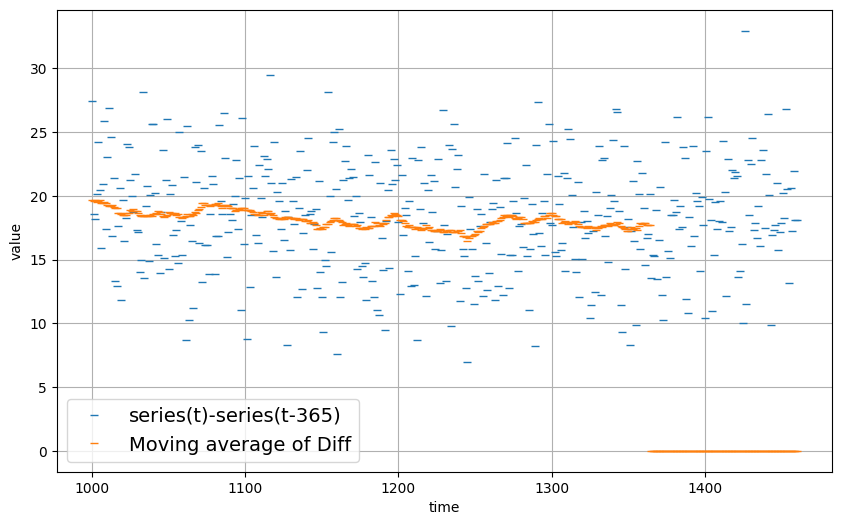

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 5 : split_time - 5]
diff_moving_avg = np.pad(diff_moving_avg, (0, len(time_valid) - len(diff_moving_avg)), 'constant')

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="series(t)-series(t-365)")
plot_series(time_valid, diff_moving_avg, label="Moving average of Diff")
plt.show()

In [ ]:
print(len(time_valid))
print(len(diff_moving_avg))

461
461


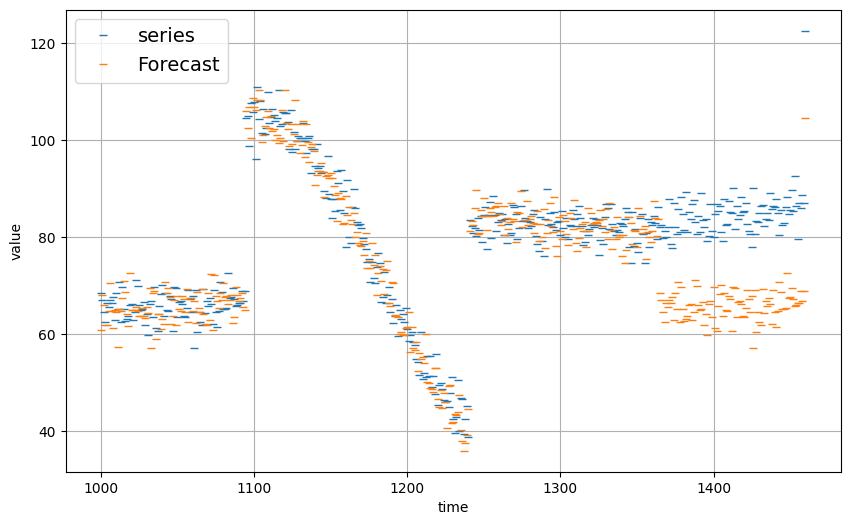

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label = "series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecast")
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg).numpy()

63.855637892159955

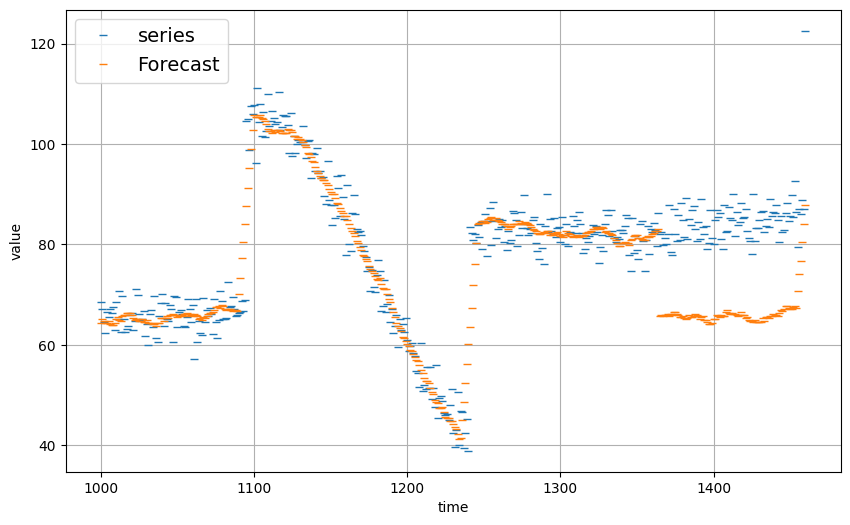

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label = "series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label = "Forecast")
plt.show()